age — возраст
sex — пол (1 - мужчина, 0 - женщина)
cp — тип боли в груди (4 значения)
trestbps — артериальное давление в покое
chol — холестерин сыворотки в мг/дл
fbs — уровень сахара в крови натощак > 120 мг/дл
restecg — результаты электрокардиографии в покое (значения 0,1,2)
thalach — достигнута максимальная частота сердечных сокращений
exang — стенокардия, вызванная физической нагрузкой
oldpeak — депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя
slope — наклон пикового сегмента ST при нагрузке
ca — количество крупных сосудов (0-3), окрашенных при флюроскопии
thal — дефект, где 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

heart = pd.read_csv('Data/heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
heart['old'] = (heart['age'] > 60).astype(int)

heart['old'].sum()

np.int64(79)

In [3]:
def get_trestbps_mean(age, sex):
    # sex: 1 - мужчина, 0 - женщина
    if age < 21:
        return 123 if sex == 1 else 116
    elif 21 <= age <= 30:
        return 126 if sex == 1 else 120
    elif 31 <= age <= 40:
        return 129 if sex == 1 else 127
    elif 41 <= age <= 50:
        return 135 if sex == 1 else 137
    elif 51 <= age <= 60:
        return 142 if sex == 1 else 144
    else:  # 61 и старше
        return 142 if sex == 1 else 159

heart['trestbps_mean'] = heart.apply(lambda row: get_trestbps_mean(row['age'], row['sex']), axis=1)

# Проверим результат
print(heart[['age', 'sex', 'trestbps_mean']].head(10))

print(heart.loc[300, 'trestbps_mean'])


   age  sex  trestbps_mean
0   63    1            142
1   37    1            129
2   41    0            137
3   56    1            142
4   57    0            144
5   57    1            142
6   56    0            144
7   44    1            135
8   52    1            142
9   57    1            142
142


In [4]:
import category_encoders as ce

# Список признаков для OneHotEncoding
onehot_features = ['cp', 'restecg', 'slope', 'ca', 'thal']

# Создаём OneHotEncoder (use_cat_names по умолчанию = False)
encoder = ce.OneHotEncoder(cols=onehot_features)
heart_encoded = encoder.fit_transform(heart)

# Проверяем, что исходные признаки удалены (category_encoders делает это автоматически)
# Если вдруг исходные признаки остались, можно удалить их вручную:
# heart_encoded = heart_encoded.drop(columns=onehot_features)

# Сколько признаков получилось?
print("Количество признаков после OneHotEncoding:", heart_encoded.shape[1])

Количество признаков после OneHotEncoding: 30


In [5]:
from sklearn.preprocessing import RobustScaler

numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'trestbps_mean']

scaler = RobustScaler()
heart_encoded[numeric_features] = scaler.fit_transform(heart_encoded[numeric_features])

std_chol = heart_encoded['chol'].std()
print(round(std_chol, 6))

0.816232


In [6]:
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,old,trestbps_mean
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,1,142
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0,129
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,137
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0,142
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0,0,144
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0,0,135
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,1,142
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0,0,142


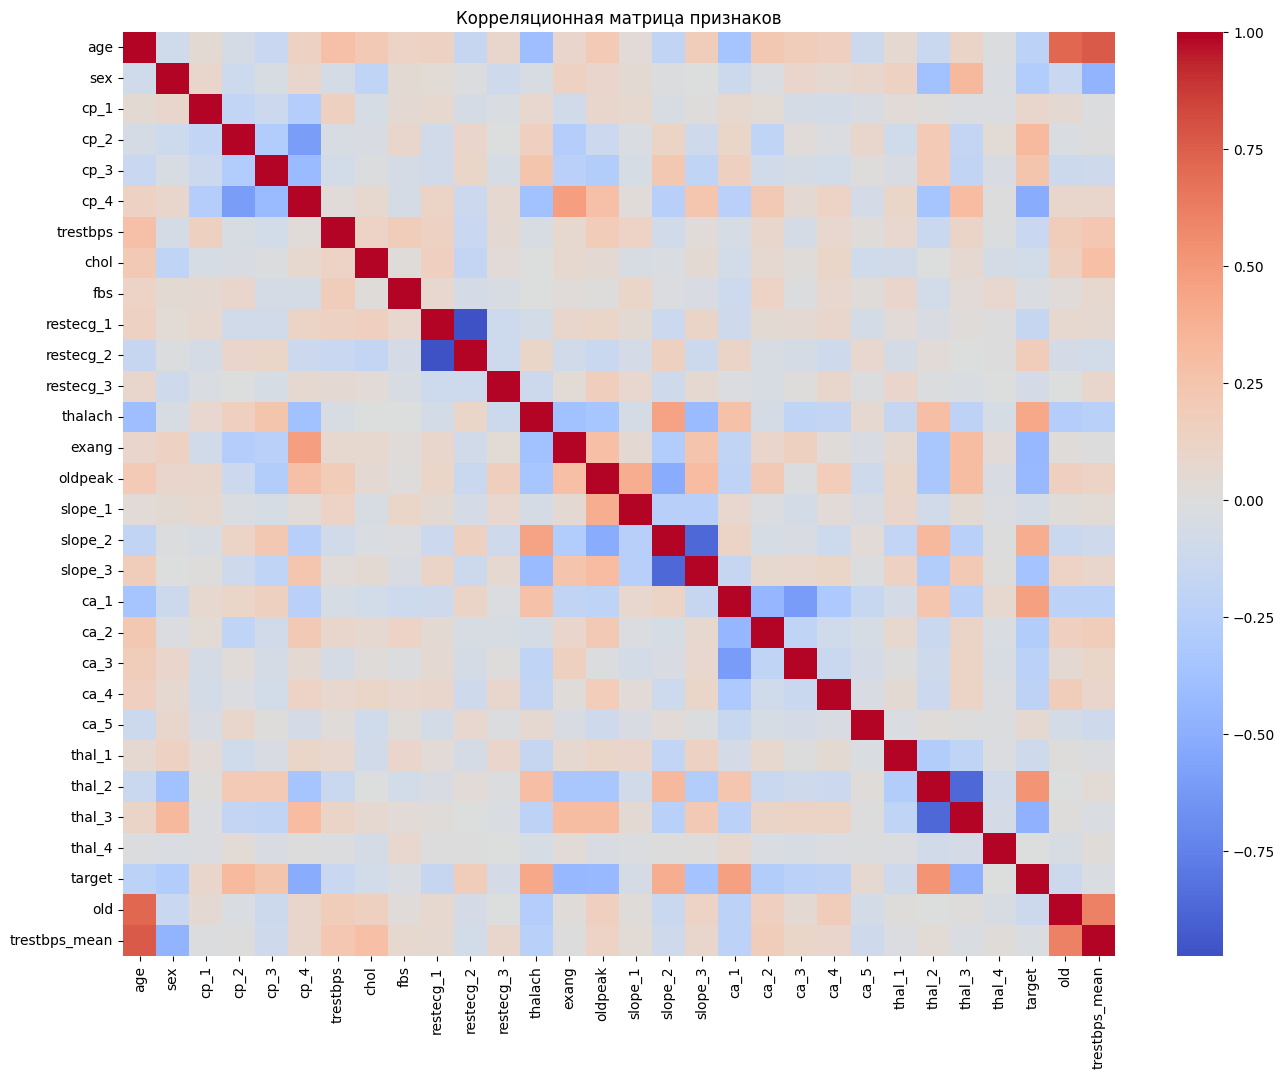

Пары сильно скоррелированных признаков (|corr| > 0.7):
      Feature1       Feature2  Correlation
27         age            old     0.718028
28         age  trestbps_mean     0.763055
225  restecg_1      restecg_2    -0.973934
344    slope_2        slope_3    -0.870365
420     thal_2         thal_3    -0.873032


In [9]:
# Корреляционная матрица
corr_matrix = heart_encoded.corr()

# Визуализация
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков')
plt.show()

# Поиск пар сильно скоррелированных признаков (|corr| > 0.7, кроме диагонали)
threshold = 0.7
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
strong_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Пары сильно скоррелированных признаков (|corr| > 0.7):")
print(strong_corr)